In [2]:
import numpy as np  
from matplotlib import pyplot as plt 
from PIL import Image   
from pytorch_lightning import Trainer   
import torch

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model  
from anomalib.data.utils import read_image
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.models.components import feature_extractors

/home/students/tyang/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OpenVINO is not installed. Please install OpenVINO to use OpenVINOInferencer.
OpenVINO is not installed. Please install OpenVINO to use OpenVINOInferencer.


To use wandb logger install it using `pip install wandb`


In [5]:
MODEL = "patchcore"
CONFIG_PATH = f"/home/students/tyang/anomalib/src/anomalib/models/{MODEL}/config.yaml"
with open(file=CONFIG_PATH, mode="r",encoding="utf-8") as f:
    print(f.read())
    
config = get_configurable_parameters(config_path=CONFIG_PATH)


dataset:
  name: airogs
  format: airogs
  path: /home/students/tyang/airogs 
  task: classification # options: [classification, segmentation]
  category: 0
  number_of_samples: 17999
  pre_selection: False
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: 224 # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.2 # fraction of train/test images held out for validation (usage depends on val_split_mode)
  tiling:
    apply: false
    tile_size: null
    stride

/home/students/tyang/anomalib/src/anomalib/config/config.py:243: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(
/home/students/tyang/anomalib/src/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


In [6]:

data_module = get_datamodule(config=config)
data_module.prepare_data() # check if the dataset is avaliable
data_module.setup()

i, val_data = next(enumerate(data_module.val_dataloader()))
print(val_data.keys())

i, train_data = next(enumerate(data_module.train_dataloader()))
print(train_data.keys())

i, test_data = next(enumerate(data_module.test_dataloader()))
print(test_data.keys())

print(train_data["image_path"][10])


dict_keys(['image_path', 'label', 'image'])
dict_keys(['image_path', 'label', 'image'])
dict_keys(['image_path', 'label', 'image'])
/home/students/tyang/airogs/0/TRAIN015272.jpg


In [4]:
print(train_data["image"].shape)

torch.Size([32, 3, 224, 224])


/home/students/tyang/anomalib/src/anomalib/pre_processing/transforms/custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


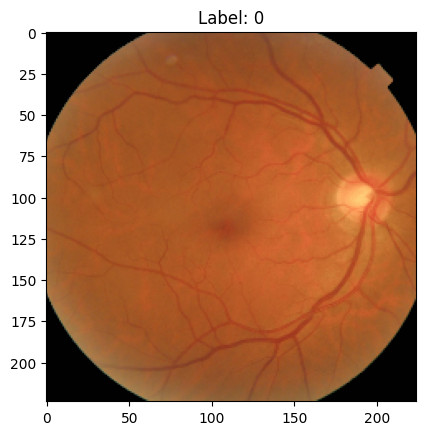

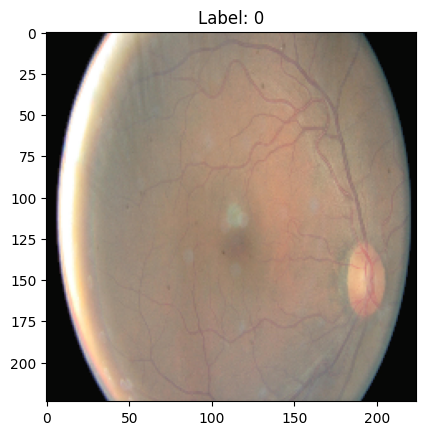

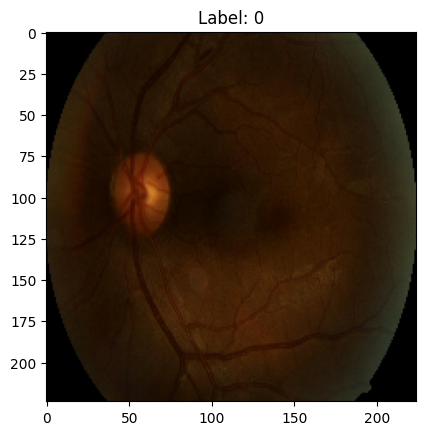

followed by valation data


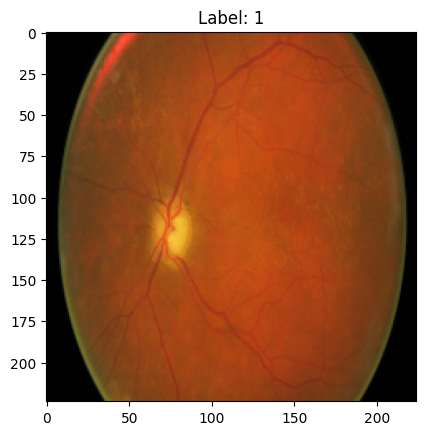

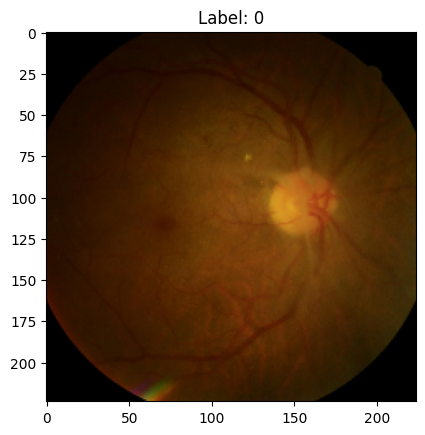

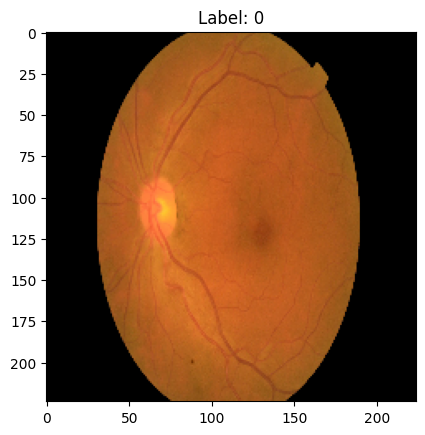

followed by test data


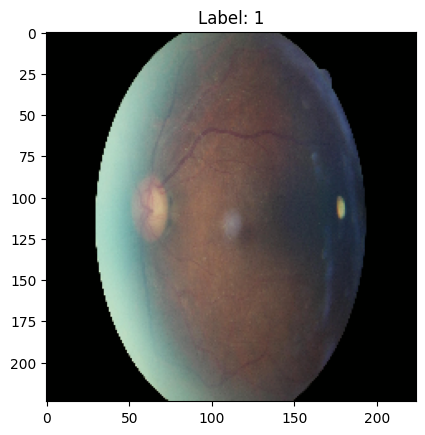

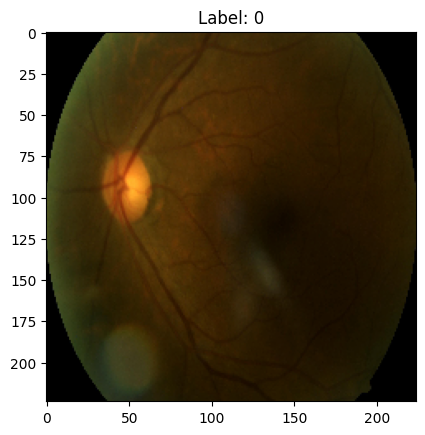

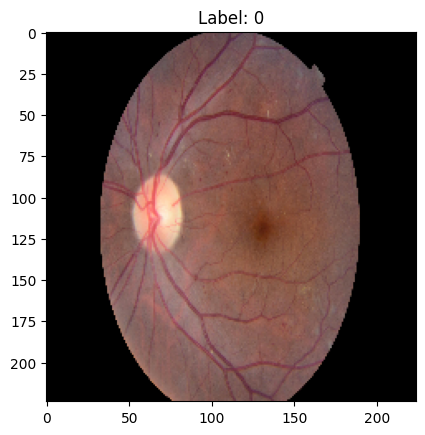

In [7]:
import random
from typing import Any
from torchvision.transforms import ToPILImage
from anomalib.pre_processing.transforms import Denormalize
def show_image(sample:dict[str, Any], idx:int):
    img = ToPILImage()(Denormalize()(sample["image"][idx]))
    plt.title(f"Label: {sample['label'][idx]}")
    plt.imshow(img)
    plt.show()

for i in range(3):
    random_idx = random.randint(0, len(train_data["label"])-1)
    show_image(sample=train_data, idx=random_idx)
print("followed by valation data")

for i in range(3):
    random_idx = random.randint(0, len(val_data["label"])-1)
    show_image(sample=val_data, idx=random_idx)
print("followed by test data")

for i in range(3):
    random_idx = random.randint(0, len(test_data["label"])-1)
    show_image(sample=test_data, idx=random_idx)
    

/tmp/ipykernel_89855/1156429866.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(train_data["label"])


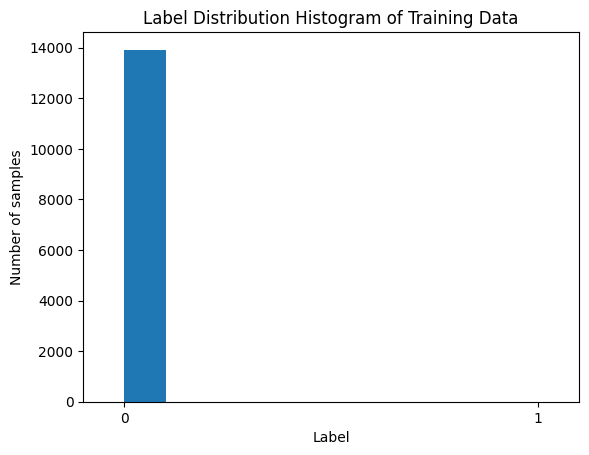

/tmp/ipykernel_89855/1156429866.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(test_data["label"])


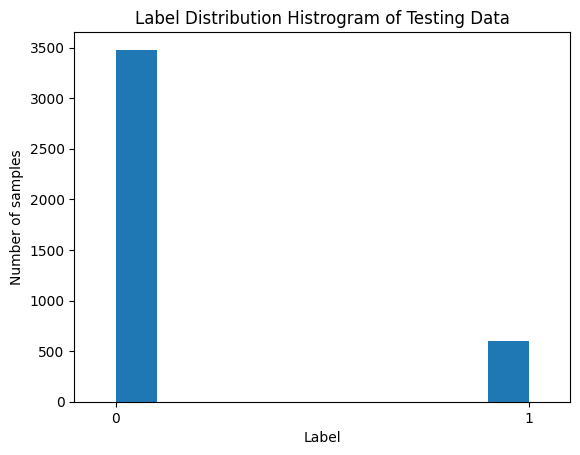

In [8]:



def show_label_histogram(data):
    label_list = [0 , 1]
    plt.hist(data)
    plt.xticks(label_list)
    plt.xlabel("Label")
    plt.ylabel("Number of samples")
    plt.xlim(-0.1,1.1)
    plt.show()

train_labels= []
for i,train_data in enumerate(data_module.train_dataloader()):
    labels = torch.tensor(train_data["label"])
    train_labels.append(labels)
train_labels = torch.cat(train_labels)    
plt.title("Label Distribution Histogram of Training Data")
show_label_histogram(train_labels)


test_labels= []
for i,test_data in enumerate(data_module.test_dataloader()):
    labels = torch.tensor(test_data["label"])
    test_labels.append(labels)
test_labels = torch.cat(test_labels) 
plt.title("Label Distribution Histrogram of Testing Data")
show_label_histogram(test_labels)

In [7]:
import torchvision
from anomalib.models.components.feature_extractors import TorchFXFeatureExtractor
from torchvision.models.densenet import DenseNet201_Weights

import torchvision.models as models
print(torchvision.models.feature_extraction.get_graph_node_names(models.densenet201(pretrained=True)))
feature_extractor = TorchFXFeatureExtractor(
                    backbone="densenet201",
                    return_nodes=["adaptive_avg_pool2d"],
                    weights=DenseNet201_Weights.IMAGENET1K_V1,
                )

features = feature_extractor(train_data["image"])
print(len(features))
print(features.keys())
print(features["adaptive_avg_pool2d"].shape)

/home/students/tyang/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/students/tyang/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/students/tyang/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/students/tyang/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torch/over

(['x', 'features.conv0', 'features.norm0', 'features.relu0', 'features.pool0', 'features.denseblock1.denselayer1.cat', 'features.denseblock1.denselayer1.norm1', 'features.denseblock1.denselayer1.relu1', 'features.denseblock1.denselayer1.conv1', 'features.denseblock1.denselayer1.norm2', 'features.denseblock1.denselayer1.relu2', 'features.denseblock1.denselayer1.conv2', 'features.denseblock1.denselayer2.cat', 'features.denseblock1.denselayer2.norm1', 'features.denseblock1.denselayer2.relu1', 'features.denseblock1.denselayer2.conv1', 'features.denseblock1.denselayer2.norm2', 'features.denseblock1.denselayer2.relu2', 'features.denseblock1.denselayer2.conv2', 'features.denseblock1.denselayer3.cat', 'features.denseblock1.denselayer3.norm1', 'features.denseblock1.denselayer3.relu1', 'features.denseblock1.denselayer3.conv1', 'features.denseblock1.denselayer3.norm2', 'features.denseblock1.denselayer3.relu2', 'features.denseblock1.denselayer3.conv2', 'features.denseblock1.denselayer4.cat', 'feat

1
dict_keys(['adaptive_avg_pool2d'])
torch.Size([30, 1920, 1, 1])


In [8]:
from anomalib.models.components.cluster.kmeans import KMeans
import torch

feature_tensor = features["adaptive_avg_pool2d"]
#kmeans = KMeans(n_clusters=4)
#kmeans.fit(feature_tensor)
#import ipdb; ipdb.set_trace()
#clusters_centers = kmeans.cluster_centers_

print(feature_tensor)

tensor([[[[5.6335e-05]],

         [[9.4134e-04]],

         [[1.7633e-03]],

         ...,

         [[7.7159e-01]],

         [[2.7843e-01]],

         [[4.3229e-01]]],


        [[[6.1727e-05]],

         [[7.7067e-04]],

         [[2.2085e-03]],

         ...,

         [[2.7245e+00]],

         [[2.0002e-01]],

         [[1.2488e-01]]],


        [[[7.6765e-05]],

         [[1.1626e-03]],

         [[2.0518e-03]],

         ...,

         [[2.0964e+00]],

         [[8.5066e-01]],

         [[2.6820e-01]]],


        ...,


        [[[3.3141e-05]],

         [[9.6233e-04]],

         [[1.1189e-03]],

         ...,

         [[5.2138e-01]],

         [[7.0255e-02]],

         [[7.1258e-03]]],


        [[[8.6862e-05]],

         [[9.5297e-04]],

         [[1.1944e-03]],

         ...,

         [[8.4306e-01]],

         [[4.8066e-01]],

         [[1.2861e+00]]],


        [[[1.8611e-05]],

         [[8.7873e-04]],

         [[1.2522e-03]],

         ...,

         [[9.4949e-01]],

 

In [9]:

import torch.nn.functional as F


def kl_divergence_filter(feature_tensor):
    
    tensor_size = feature_tensor.shape[0]
    kl_divergences = torch.zeros((tensor_size, tensor_size))
    for i in range(tensor_size):
      for j in range(i+1, tensor_size):
        feature_i = feature_tensor[i].view(-1)
        feature_j = feature_tensor[j].view(-1)

        kl_divergences[i,j] = F.kl_div(F.softmax(feature_i,dim=0).log(), F.softmax(feature_j,dim=0))
        kl_divergences[j,i] = F.kl_div(F.softmax(feature_j,dim=0).log(), F.softmax(feature_i,dim=0))
    
    average_kl_divergences = torch.mean(kl_divergences, dim=1)
    most_unique_idx = torch.argmax(average_kl_divergences)
    most_unique_data = dict(image_path = train_data["image_path"][most_unique_idx],
                            label = train_data["label"][most_unique_idx],
                            image = train_data["image"][most_unique_idx])


    return most_unique_data



most_unique_data = kl_divergence_filter(feature_tensor)
print(most_unique_data["image_path"])
print(most_unique_data["label"])
print(most_unique_data["image"].shape)

/home/students/tyang/airogs/0/TRAIN015799.jpg
tensor(0)
torch.Size([3, 224, 224])


/home/students/tyang/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


In [10]:

def process_train_data(train_data):

    features = feature_extractor(train_data["image"])
    feature_tensor = features["adaptive_avg_pool2d"]
    most_unique_pict = kl_divergence_filter(feature_tensor)

    return most_unique_pict



merged_data = {"image_path":[], "label":[], "image":[]}
for  i, train_data in enumerate(data_module.train_dataloader()):
    unique_data = process_train_data(train_data)
    
    for key, values in unique_data.items():
        merged_data[key].append(values)

print(merged_data["image_path"])


['/home/students/tyang/airogs/0/TRAIN007584.jpg', '/home/students/tyang/airogs/0/TRAIN009114.jpg', '/home/students/tyang/airogs/0/TRAIN009357.jpg', '/home/students/tyang/airogs/0/TRAIN017292.jpg', '/home/students/tyang/airogs/0/TRAIN008817.jpg', '/home/students/tyang/airogs/0/TRAIN005422.jpg', '/home/students/tyang/airogs/0/TRAIN016686.jpg', '/home/students/tyang/airogs/0/TRAIN008028.jpg', '/home/students/tyang/airogs/0/TRAIN008748.jpg', '/home/students/tyang/airogs/0/TRAIN002009.jpg', '/home/students/tyang/airogs/0/TRAIN009380.jpg', '/home/students/tyang/airogs/0/TRAIN009532.jpg', '/home/students/tyang/airogs/0/TRAIN012000.jpg', '/home/students/tyang/airogs/0/TRAIN000865.jpg', '/home/students/tyang/airogs/0/TRAIN006968.jpg', '/home/students/tyang/airogs/0/TRAIN000237.jpg', '/home/students/tyang/airogs/0/TRAIN000288.jpg', '/home/students/tyang/airogs/0/TRAIN009208.jpg', '/home/students/tyang/airogs/0/TRAIN011038.jpg', '/home/students/tyang/airogs/0/TRAIN012097.jpg', '/home/students/tya

In [11]:
import csv 
import os
csv_path = "/home/students/tyang/Documents/new_trainingdata.csv"

#if not os.path.isfile(csv_path):
with open(csv_path, mode="w", newline="") as csv_file:
        fieldnames = ["image_path", "label", "image"]
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        for i in range(len(merged_data["image_path"])):
            rowdict = {"image_path": merged_data["image_path"][i], "label": merged_data["label"][i], "image": merged_data["image"][i]}
            writer.writerow(rowdict)
            #row = {"image_path": merged_data["image_path"][i], "label": merged_data["label"][i], "image": merged_data["image"][i]}
            #writer.writerow(row)





dataset:
  name: airogs
  format: airogs
  path: /home/students/tyang/airogs 
  task: classification # options: [classification, segmentation]
  category: 0
  pre_selection: True
  number_of_samples: 300
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: 224 # dimensions to which images are center-cropped after resizing (optional)
  normalization: imagenet # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_test, from_test, synthetic]
  val_split_ratio: 0.2 # fraction of train/test images held out for validation (usage depends on val_split_mode)

  tiling:
    apply: false
    tile_size: null
    stride: 

/home/students/tyang/anomalib/src/anomalib/config/config.py:243: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(
/home/students/tyang/anomalib/src/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


dict_keys(['image_path', 'label', 'image'])


/home/students/tyang/anomalib/src/anomalib/pre_processing/transforms/custom.py:25: UserWarning: Denormalize is no longer used and will be deprecated in v0.4.0
  warnings.warn("Denormalize is no longer used and will be deprecated in v0.4.0")


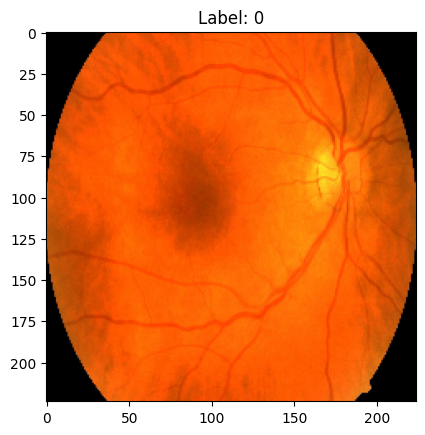

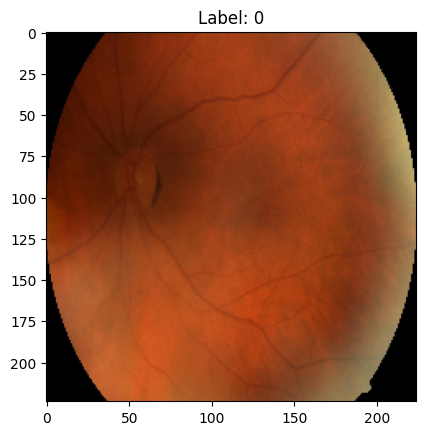

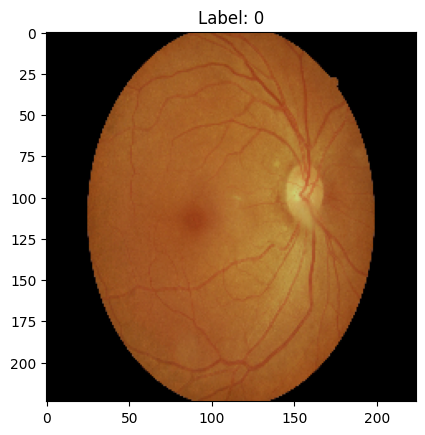

/tmp/ipykernel_89855/3898696337.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(train_data["label"])


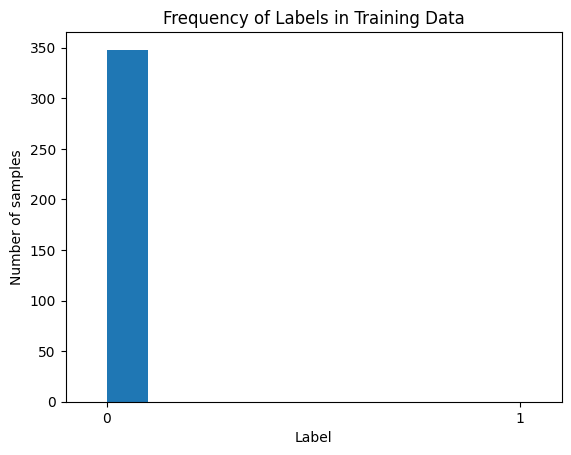

/tmp/ipykernel_89855/3898696337.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(test_data["label"])


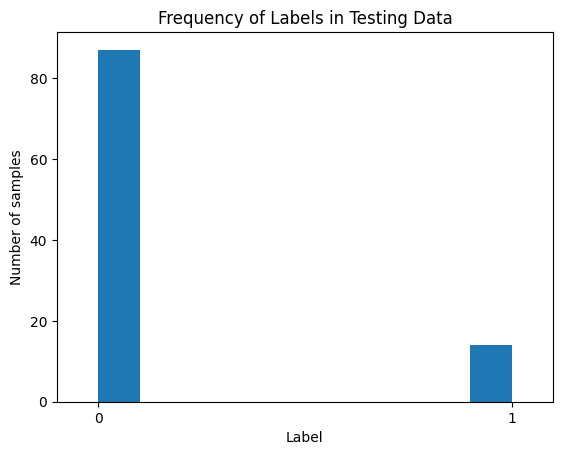

In [21]:
import random

MODEL = "patchcore"
CONFIG_SELECT_PATH = f"/home/students/tyang/anomalib/src/anomalib/models/{MODEL}/config_select.yaml"
with open(file=CONFIG_SELECT_PATH, mode="r",encoding="utf-8") as f:
    print(f.read())
    
config_select = get_configurable_parameters(config_path=CONFIG_SELECT_PATH)

data_module_select = get_datamodule(config=config_select)
#data_module.prepare_data() # check if the dataset is avaliable
data_module_select.setup()

i, train_data_select = next(enumerate(data_module_select.train_dataloader()))
print(train_data_select.keys())
for i in range(3):
    random_idx = random.randint(0, len(train_data_select["label"])-1)
    show_image(sample=train_data_select, idx=random_idx)


train_select_labels= []
for i,train_data in enumerate(data_module_select.train_dataloader()):
    labels = torch.tensor(train_data["label"])
    train_select_labels.append(labels)
train_select_labels = torch.cat(train_select_labels)    
plt.title("Frequency of Labels in Training Data")
show_label_histogram(train_select_labels)


test_select_labels= []
for i,test_data in enumerate(data_module_select.test_dataloader()):
    labels = torch.tensor(test_data["label"])
    test_select_labels.append(labels)
test_select_labels = torch.cat(test_select_labels) 
plt.title("Frequency of Labels in Testing Data")
show_label_histogram(test_select_labels)

In [22]:
from anomalib.utils.loggers import get_experiment_logger


model_select = get_model(config=config_select)    
experiment_logger = get_experiment_logger(config=config_select)
callbacks = get_callbacks(config=config_select)

trainer = Trainer(**config_select.trainer, callbacks=callbacks)
trainer.fit(model=model_select, train_dataloaders=data_module_select.train_dataloader(), val_dataloaders=data_module_select.val_dataloader())


/home/students/tyang/miniconda3/envs/anomalib_env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


/home/students/tyang/anomalib/src/anomalib/utils/callbacks/__init__.py:153: UserWarning: Export option: None not found. Defaulting to no model export
  warnings.warn(f"Export option: {config.optimization.export_mode} not found. Defaulting to no model export")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Cannot perform pixel-level evaluation when task type is classification. Ignoring the following pixel-level metrics: ['F1

Epoch 0:  53%|█████▎    | 8/15 [00:04<00:04,  1.61it/s, loss=nan, v_num=31]

Selecting Coreset Indices.: 100%|██████████| 96000/96000 [07:27<00:00, 214.46it/s]


Epoch 0:  73%|███████▎  | 11/15 [07:34<02:45, 41.30s/it, loss=nan, v_num=31]




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































Selecting Coreset Indices.: 100%|██████████| 28608/28608 [01:33<00:00, 305.38

Epoch 0: 100%|██████████| 15/15 [09:13<00:00, 36.91s/it, loss=nan, v_num=31, image_F1Score=0.474, image_AUROC=0.826]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 15/15 [09:16<00:00, 37.12s/it, loss=nan, v_num=31, image_F1Score=0.474, image_AUROC=0.826]


In [23]:
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model_select, datamodule=data_module_select)

Cannot perform pixel-level evaluation when task type is classification. Ignoring the following pixel-level metrics: ['F1Score', 'AUROC']
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 4/4 [00:27<00:00,  6.79s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC           0.825944185256958
      image_F1Score         0.47368425130844116
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
